In [1]:
!pip install transformers psycopg2 numpy boto3 torch scikit-learn matplotlib nltk sentence-transformers


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Pool
from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch
import psycopg2
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import json
import os

/home/antoine/.pyenv/versions/3.10.11/envs/shinobi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model

In [3]:
models = {
    "bart": {
        "model_name": "facebook/bart-large",
        "tokenizer": AutoTokenizer.from_pretrained("facebook/bart-large", trust_remote_code=True),
        "model": AutoModel.from_pretrained("facebook/bart-large", trust_remote_code=True)
    },
    "gte": {
        "model_name": "Alibaba-NLP/gte-large-en-v1.5",
        "tokenizer": AutoTokenizer.from_pretrained("Alibaba-NLP/gte-large-en-v1.5", trust_remote_code=True),
        "model": AutoModel.from_pretrained("Alibaba-NLP/gte-large-en-v1.5", trust_remote_code=True)
    },
    "MiniLM": {
        "model_name": 'all-MiniLM-L12-v2',
        "model": SentenceTransformer('all-MiniLM-L12-v2')
    }
}

# Test Cosine Similarity with embeddings

In [4]:

# Example sentences
sentences_test = ["This is a fox.", "This is a dog.", "This is a cat.", "This is a fox."]

# Generate embeddings
embeddings_test = models["MiniLM"]["model"].encode(sentences_test)

# Calculate cosine similarity
cosine_similarity = np.dot(embeddings_test[0], embeddings_test[1]) / (np.linalg.norm(embeddings_test[0]) * np.linalg.norm(embeddings_test[1]))
print("Cosine Similarity:", cosine_similarity)
cosine_similarity = np.dot(embeddings_test[0], embeddings_test[3]) / (np.linalg.norm(embeddings_test[0]) * np.linalg.norm(embeddings_test[3]))
print("Cosine Similarity Same:", cosine_similarity)

Cosine Similarity: 0.46493083
Cosine Similarity Same: 1.0


# Remove stopwords to reduce noise

In [5]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/antoine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Define a list of movie titles

In [6]:
current_directory = os.getcwd()
with open(os.path.join(current_directory, "movies.json"), "r") as f:
    movies = json.load(f)

movies_data = []
for movie in movies["films"]["film"]:

    roles = movie.get("role", [])
    if isinstance(roles, dict):  # If 'roles' is a dictionary, make it a single-item list
        roles = [roles]

    # Extract actor information
    actors = []
    for role in roles:
        actor_info = role.get("acteur", {})
        if "__text" in actor_info:
            actors.append(actor_info["__text"])

    movies_data.append({
        "title": movie.get("titre", ""),
        "year": movie.get("annee", ""),
        "country": movie.get("pays", ""),
        "language": movie.get("langue", ""),
        "duration": movie.get("duree", ""),
        "summary": movie.get("synopsis", ""),
        "genre": movie.get("genre", ""),
        "director": movie.get("realisateur", {"__text": ""}).get("__text", ""),
        "writers": movie.get("scenariste", []),
        "actors": actors,
        "poster": movie.get("affiche", ""),
        "id": movie.get("id", "")
    })

# Generate embeddings for movies

In [7]:
def preprocess(text):
    # Example preprocessing step simplified for demonstration
    tokens = text.split()
    # Assuming stopwords are already loaded to avoid loading them in each process
    stopwords_set = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stopwords_set]
    return ' '.join(tokens)

In [8]:
def generate_embedding(movies_data, model_key):
    model_config = models[model_key]
    if 'tokenizer' in model_config:
        # Handle HuggingFace transformer models
        movie_texts = [
            f"{preprocess(movie['title'])} {movie['year']} {' '.join(movie['genre'])} "
            f"{' '.join(movie['actors'])} {movie['director']} "
            f"{preprocess(movie['summary'])} {movie['country']}"
            for movie in movies_data
        ]
        inputs = model_config['tokenizer'](movie_texts, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = model_config['model'](**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    else:
        # Handle Sentence Transformers
        movie_texts = [
            f"{movie['title']} {movie['year']} {' '.join(movie['genre'])} "
            f"{preprocess(movie['summary'])}"
            for movie in movies_data
        ]
        embeddings = model_config['model'].encode(movie_texts)

    return embeddings


In [9]:
embeddings_bart = generate_embedding(movies_data, 'bart')
embeddings_bart = np.array(embeddings_bart)
print("BART embeddings shape:", embeddings_bart.shape)
print("BART embeddings:", embeddings_bart[0])

BART embeddings shape: (631, 1024)
BART embeddings: [ 0.61673295  0.327278   -0.33701357 ... -0.11525329 -0.59431905
 -0.50281   ]


In [10]:
embeddings_gte = generate_embedding(movies_data, 'gte')
embeddings_gte = np.array(embeddings_gte)
print("GTE embeddings shape:", embeddings_gte.shape)
print("GTE embeddings:", embeddings_gte[0])

GTE embeddings shape: (631, 1024)
GTE embeddings: [ 0.06353578  0.12969953  0.27949515 ...  0.95282686 -0.22997235
 -0.501011  ]


In [11]:
embeddings_MiniLM = generate_embedding(movies_data, 'MiniLM')
embeddings_MiniLM = np.array(embeddings_MiniLM)
print("MiniLM embeddings shape:", embeddings_MiniLM.shape)
print("MiniLM embeddings:", embeddings_MiniLM[0])

MiniLM embeddings shape: (631, 384)
MiniLM embeddings: [-1.63247474e-02 -8.06933385e-05  1.17272697e-01 -1.14815533e-02
  1.02172485e-02  9.15275961e-02  4.14475128e-02  3.41122448e-02
  7.03344047e-02  5.40169701e-02 -5.55625223e-02  3.95422131e-02
 -2.91470159e-02  6.52294308e-02 -3.23168077e-02  8.01149234e-02
  2.92451493e-02  1.15465865e-01  2.59744143e-03  1.42910297e-03
 -5.57408705e-02  5.44920377e-02  5.59100509e-03  8.33349302e-03
  2.09129304e-02 -1.63049158e-02  4.19383869e-03 -4.28651497e-02
 -3.31980251e-02 -4.21339944e-02  6.46726638e-02  3.54333967e-02
 -4.71519399e-03  9.14208218e-03 -1.42402845e-02  4.44623642e-02
 -1.30040213e-01 -7.63623230e-03 -1.02645494e-02 -4.95107099e-02
  1.08102895e-02 -7.72702321e-03  1.27679065e-01 -1.04855046e-01
 -2.30962764e-02 -3.84617522e-02 -3.12902741e-02 -2.72346232e-02
  5.13743646e-02  5.99684566e-02 -7.80581608e-02 -8.83473922e-03
 -2.59092059e-02  1.55808879e-02 -3.48069868e-03 -6.76053688e-02
  2.46603717e-03  9.60725453e-03 -5

# Create connection to the database

In [116]:
conn = psycopg2.connect(database="admin", host="localhost", user="admin", password="admin", port="5432")
cur = conn.cursor()

In [117]:
cur.execute("CREATE EXTENSION IF NOT EXISTS vector;")
conn.commit()

In [118]:
def setup_database():
    cur.execute('DROP TABLE IF EXISTS movies')
    cur.execute('''
        CREATE TABLE movies (
            id SERIAL PRIMARY KEY,
            title TEXT NOT NULL,
            actors TEXT,
            year INTEGER,
            country TEXT,
            language TEXT,
            duration INTEGER,
            summary TEXT,
            genre TEXT[],
            director TEXT,
            scenarists TEXT[],
            poster TEXT,
            embedding_bart VECTOR(1024),
            embedding_gte VECTOR(1024),
            embedding_MiniLM VECTOR(384)
        );
    ''')
    conn.commit()

setup_database()


# Insert movie titles and their embeddings into the 'movies' table

In [119]:
def insert_movies(movie_data, embeddings_bart, embeddings_gte, embeddings_MiniLM):
    for movie, emb_bart, emb_gte, emb_MiniLM in zip(movie_data, embeddings_bart, embeddings_gte, embeddings_MiniLM):
        # Joining actors into a single string separated by commas
        actor_names = ', '.join(movie['actors'])
        # Convert list of genres into a PostgreSQL array format
        genre_array = '{' + ', '.join([f'"{g}"' for g in movie['genre']]) + '}'
        # Convert list of scenarists into a PostgreSQL array format
        scenarist_array = '{' + ', '.join([f'"{s}"' for s in movie['writers']]) + '}'
        # Convert embeddings to a string properly formatted as a list
        embedding_bart_str = '[' + ', '.join(map(str, emb_bart)) + ']'
        embedding_gte_str = '[' + ', '.join(map(str, emb_gte)) + ']'
        embedding_MiniLM_str = '[' + ', '.join(map(str, emb_MiniLM)) + ']'

        cur.execute('''
            INSERT INTO movies (title, actors, year, country, language, duration, summary, genre, director, scenarists, poster, embedding_bart, embedding_gte, embedding_MiniLM)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        ''', (
            movie['title'], actor_names, movie['year'], movie['country'], movie['language'],
            movie['duration'], movie['summary'], genre_array, movie['director'],
            scenarist_array, movie['poster'], embedding_bart_str, embedding_gte_str, embedding_MiniLM_str
        ))
    conn.commit()

In [120]:
insert_movies(movies_data, embeddings_bart, embeddings_gte, embeddings_MiniLM)

# Finding similar movies with Python

In [145]:
def get_query_embedding(title, embedding_type='bart'):
    cur.execute(f"SELECT embedding_{embedding_type} FROM movies WHERE title = %s", (title,))
    result = cur.fetchone()
    if result:
        embedding_str = result[0]
        embedding = [float(x) for x in embedding_str.strip('[]').split(',')]
        return np.array(embedding, dtype=float).reshape(1, -1)
    else:
        return None

In [146]:

def find_similar_movies(title, threshold=0.5, return_n=25, distance_function='cosine_similarity', embedding_type='bart'):
    query_embedding = get_query_embedding(title, embedding_type)
    if query_embedding is None:
        print(f"No embedding found for the movie titled '{title}'.")
        return []

    cur.execute(f'SELECT title, embedding_{embedding_type} FROM movies')
    rows = cur.fetchall()

    embeddings = []
    movie_titles = []
    for other_title, embedding_str in rows:
        if other_title != title:
            embedding = np.array([float(x) for x in embedding_str.strip('[]').split(',')])
            embeddings.append(embedding)
            movie_titles.append(other_title)

    if distance_function == 'cosine_similarity':
        distances = pairwise_distances(query_embedding, embeddings, metric='cosine')
        similarities = 1 - distances
    elif distance_function == 'euclidean_distance':
        distances = pairwise_distances(query_embedding, embeddings, metric='euclidean')
        similarities = 1 / (1 + distances)
    elif distance_function == 'inner_product':
        inner_products = np.dot(query_embedding, np.array(embeddings).T)
        similarities = inner_products / (np.linalg.norm(query_embedding) * np.linalg.norm(embeddings, axis=1))
    elif distance_function == 'hamming_distance':
        # convert embeddings to binary
        query_binary = np.where(query_embedding > 0, 1, 0)
        embeddings_binary = np.where(np.array(embeddings) > 0, 1, 0)
        distances = pairwise_distances(query_binary, embeddings_binary, metric='hamming')
        similarities = 1 - distances
    elif distance_function == 'jaccard_distance':
        # convert embeddings to binary
        query_binary = np.where(query_embedding > 0, 1, 0)
        embeddings_binary = np.where(np.array(embeddings) > 0, 1, 0)
        distances = pairwise_distances(query_binary, embeddings_binary, metric='jaccard')
        similarities = 1 - distances
    else:
        print("Unsupported distance function.")
        return []

    similar_movies = [(movie_titles[i], similarities[0][i]) for i in range(len(movie_titles)) if similarities[0][i] > threshold]
    similar_movies.sort(key=lambda x: x[1], reverse=True)
    return similar_movies[:return_n]


# SQL query to find similar movies

In [147]:
def find_similar_movies_sql(title, threshold=0.1, return_n=10, distance_function='<->', embedding_type='bart'):
    allowed_functions = ['<->', '<#>', '<=>', '<+>']  # L2, negative inner product, cosine, L1
    if distance_function not in allowed_functions:
        print("Unsupported distance function.")
        return []

    try:
        cur.execute(f"""
            SELECT title, embedding_{embedding_type}, embedding_{embedding_type} {distance_function} (SELECT embedding_{embedding_type} FROM movies WHERE title = %s) AS distance
            FROM movies
            WHERE title != %s
            ORDER BY distance
            LIMIT %s;
        """, (title, title, return_n))

        results = cur.fetchall()
        if distance_function == '<=>':  # Adjust for cosine similarity
            similar_movies = [(row[0], 1 - row[2]) for row in results if (1 - row[2]) > threshold]
        else:
            similar_movies = [(row[0], row[2]) for row in results if row[2] < threshold]

        return similar_movies
    except Exception as e:
        print(f"An error occurred: {e}")
        return []


# Define a query movie title

In [148]:
query_movie_title = 'The Incredibles'

# Plot

In [149]:
def plot_similar_movies(similar_movies, title):
    # Prepare data
    titles, similarities = zip(*similar_movies)
    similarities = [round(sim * 100, 3) for sim in similarities]  # Convert to percentage and round off

    # Create a vertical bar chart
    plt.figure(figsize=(12, 8))
    bars = plt.bar(titles, similarities, color='skyblue')
    plt.ylabel('Similarity Score (%)')
    plt.title(f"{title} - Similar Movies for '{query_movie_title}'")
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

In [150]:
def plot_compare_similar_movies_embedding(similar_movies_array, title):
    # Prepare data multiple plot for different embeddings
    fig, ax = plt.subplots(3, 1, figsize=(12, 24))
    for i, similar_movies in enumerate(similar_movies_array):
        titles, similarities = zip(*similar_movies)
        similarities = [round(sim * 100, 3) for sim in similarities]  # Convert to percentage and round off

        # Create a vertical bar chart
        bars = ax[i].bar(titles, similarities, color='skyblue')
        ax[i].set_ylabel('Similarity Score (%)')
        ax[i].set_title(f"{title} - Similar Movies for '{query_movie_title}' - {list(models.keys())[i]}")
        ax[i].tick_params(axis='x', rotation=45, labelsize=10)
    plt.tight_layout()
    plt.show()

# Perform a similarity search

## SQL

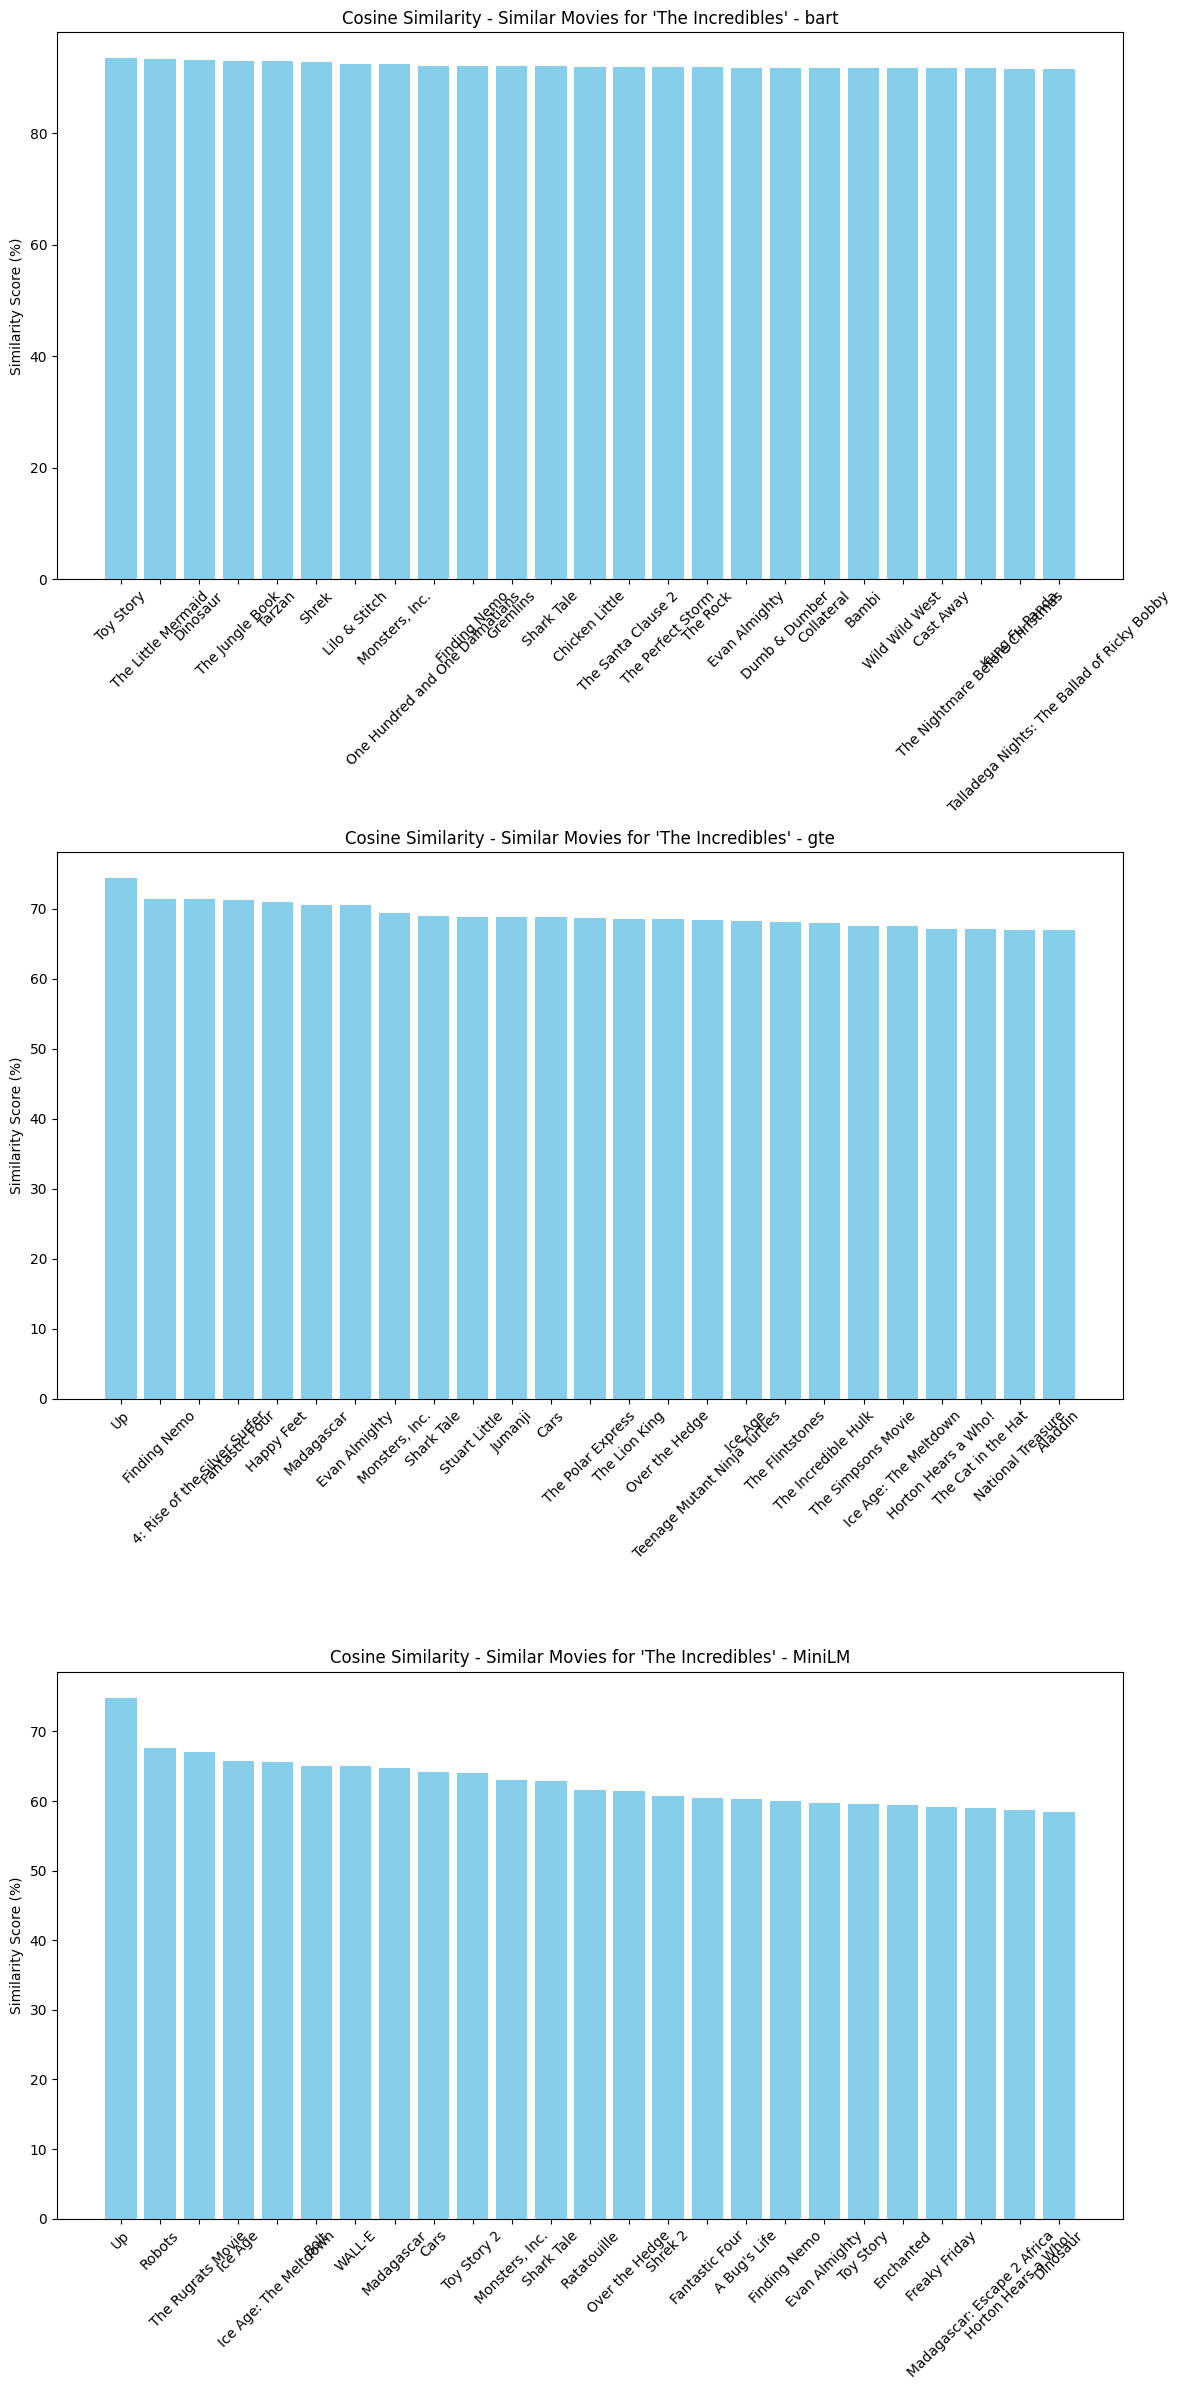

In [151]:
# For cosine similarity
similar_movies_bart = find_similar_movies_sql(query_movie_title, threshold=0, return_n=25, distance_function='<=>', embedding_type='bart')
similar_movies_gte = find_similar_movies_sql(query_movie_title, threshold=0, return_n=25, distance_function='<=>', embedding_type='gte')
similar_movies_MiniLM = find_similar_movies_sql(query_movie_title, threshold=0, return_n=25, distance_function='<=>', embedding_type='MiniLM')
plot_compare_similar_movies_embedding([similar_movies_bart, similar_movies_gte, similar_movies_MiniLM], 'Cosine Similarity')


## Python

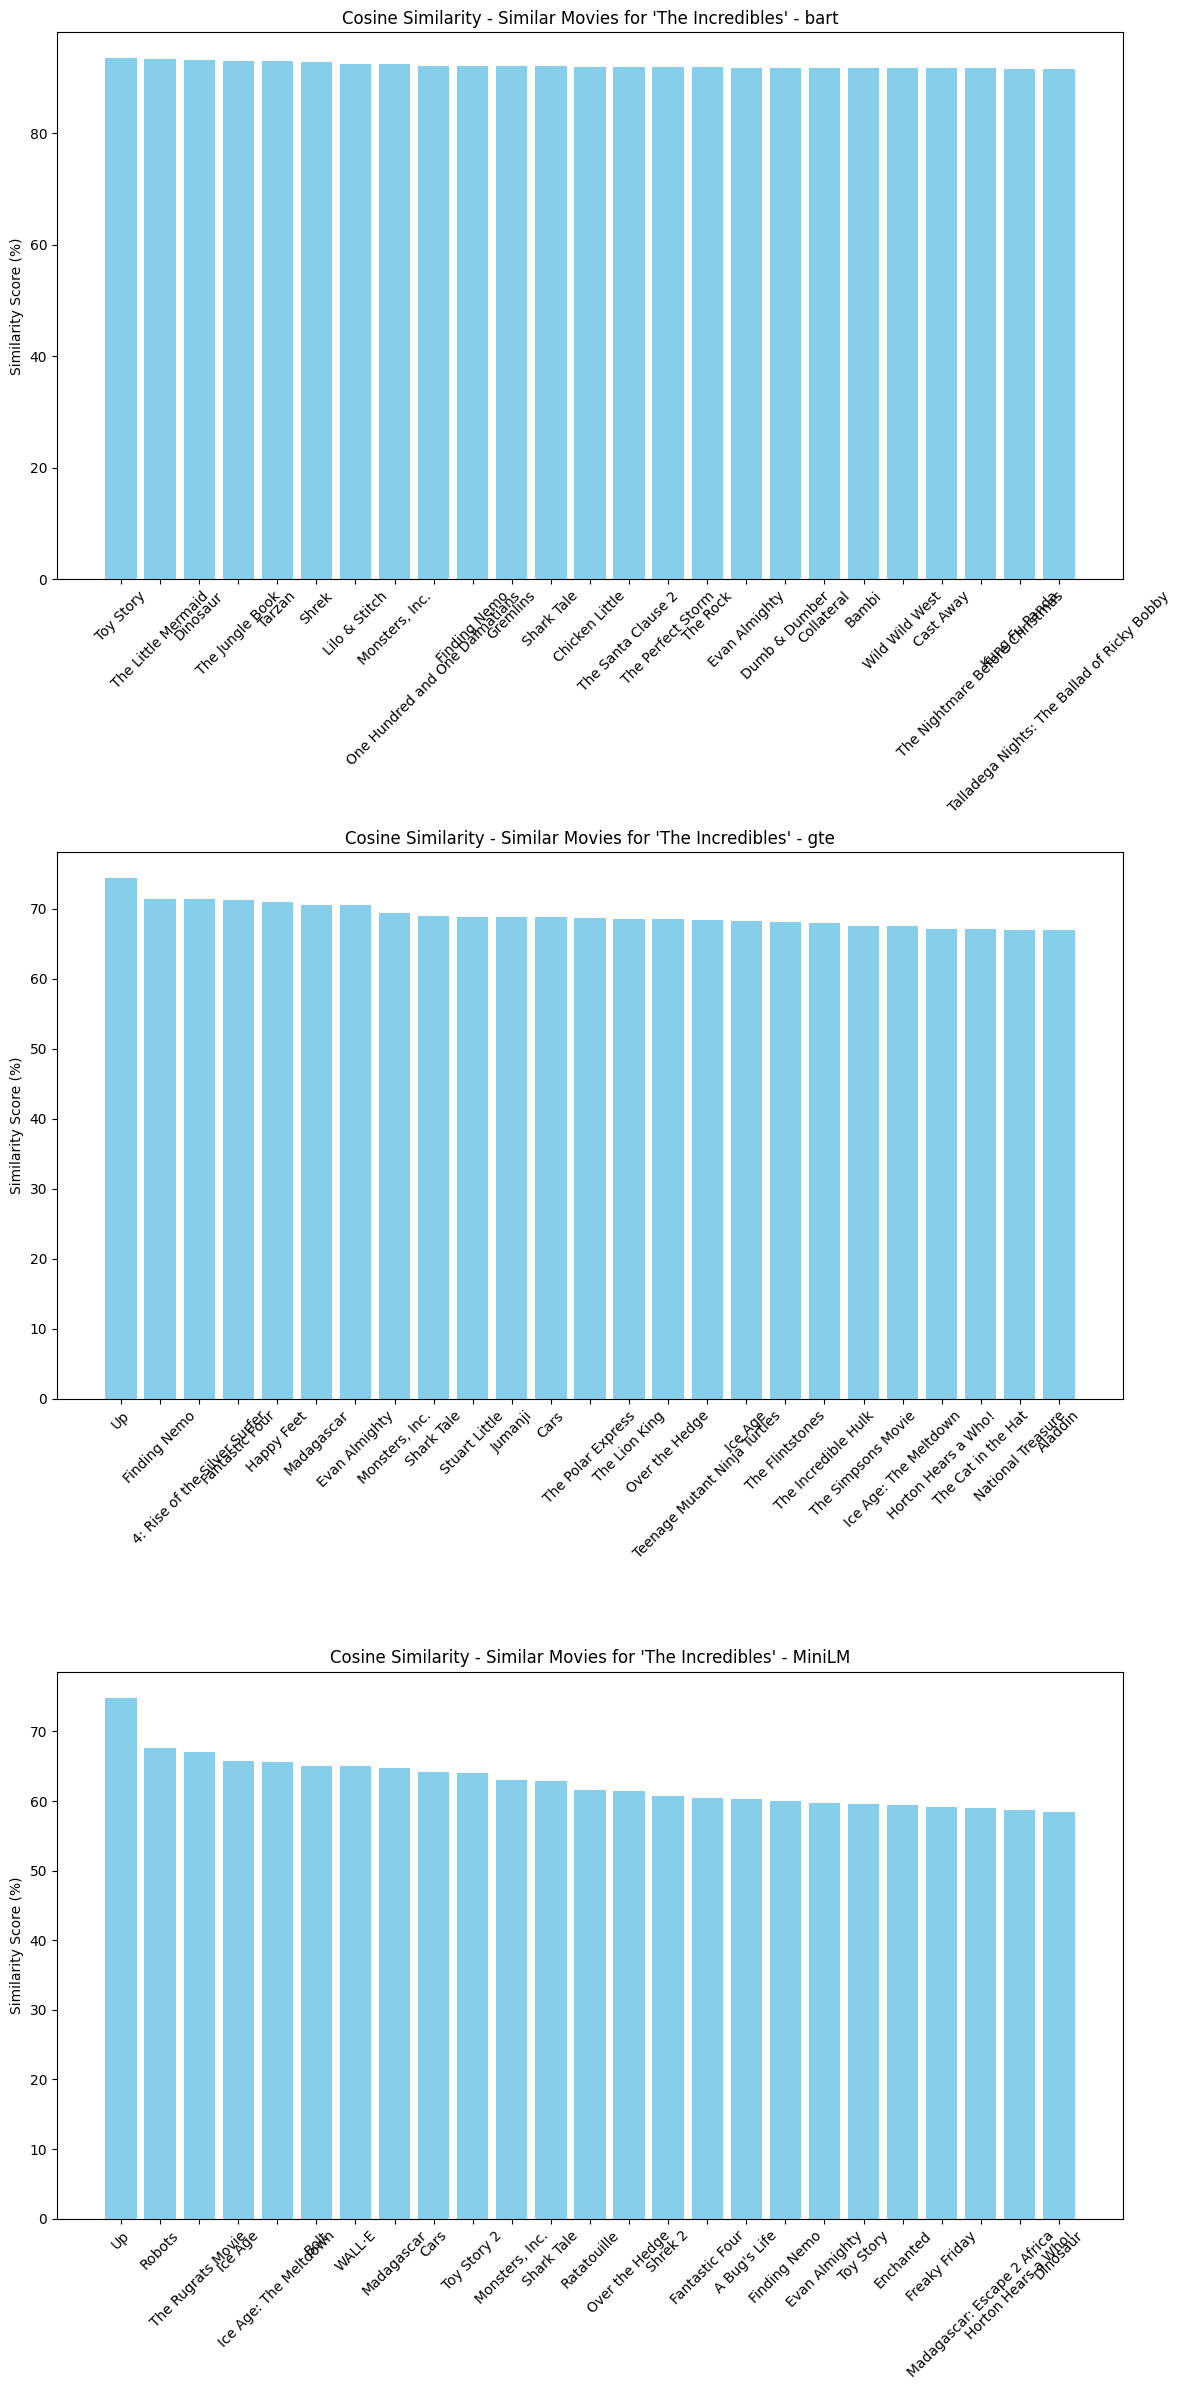

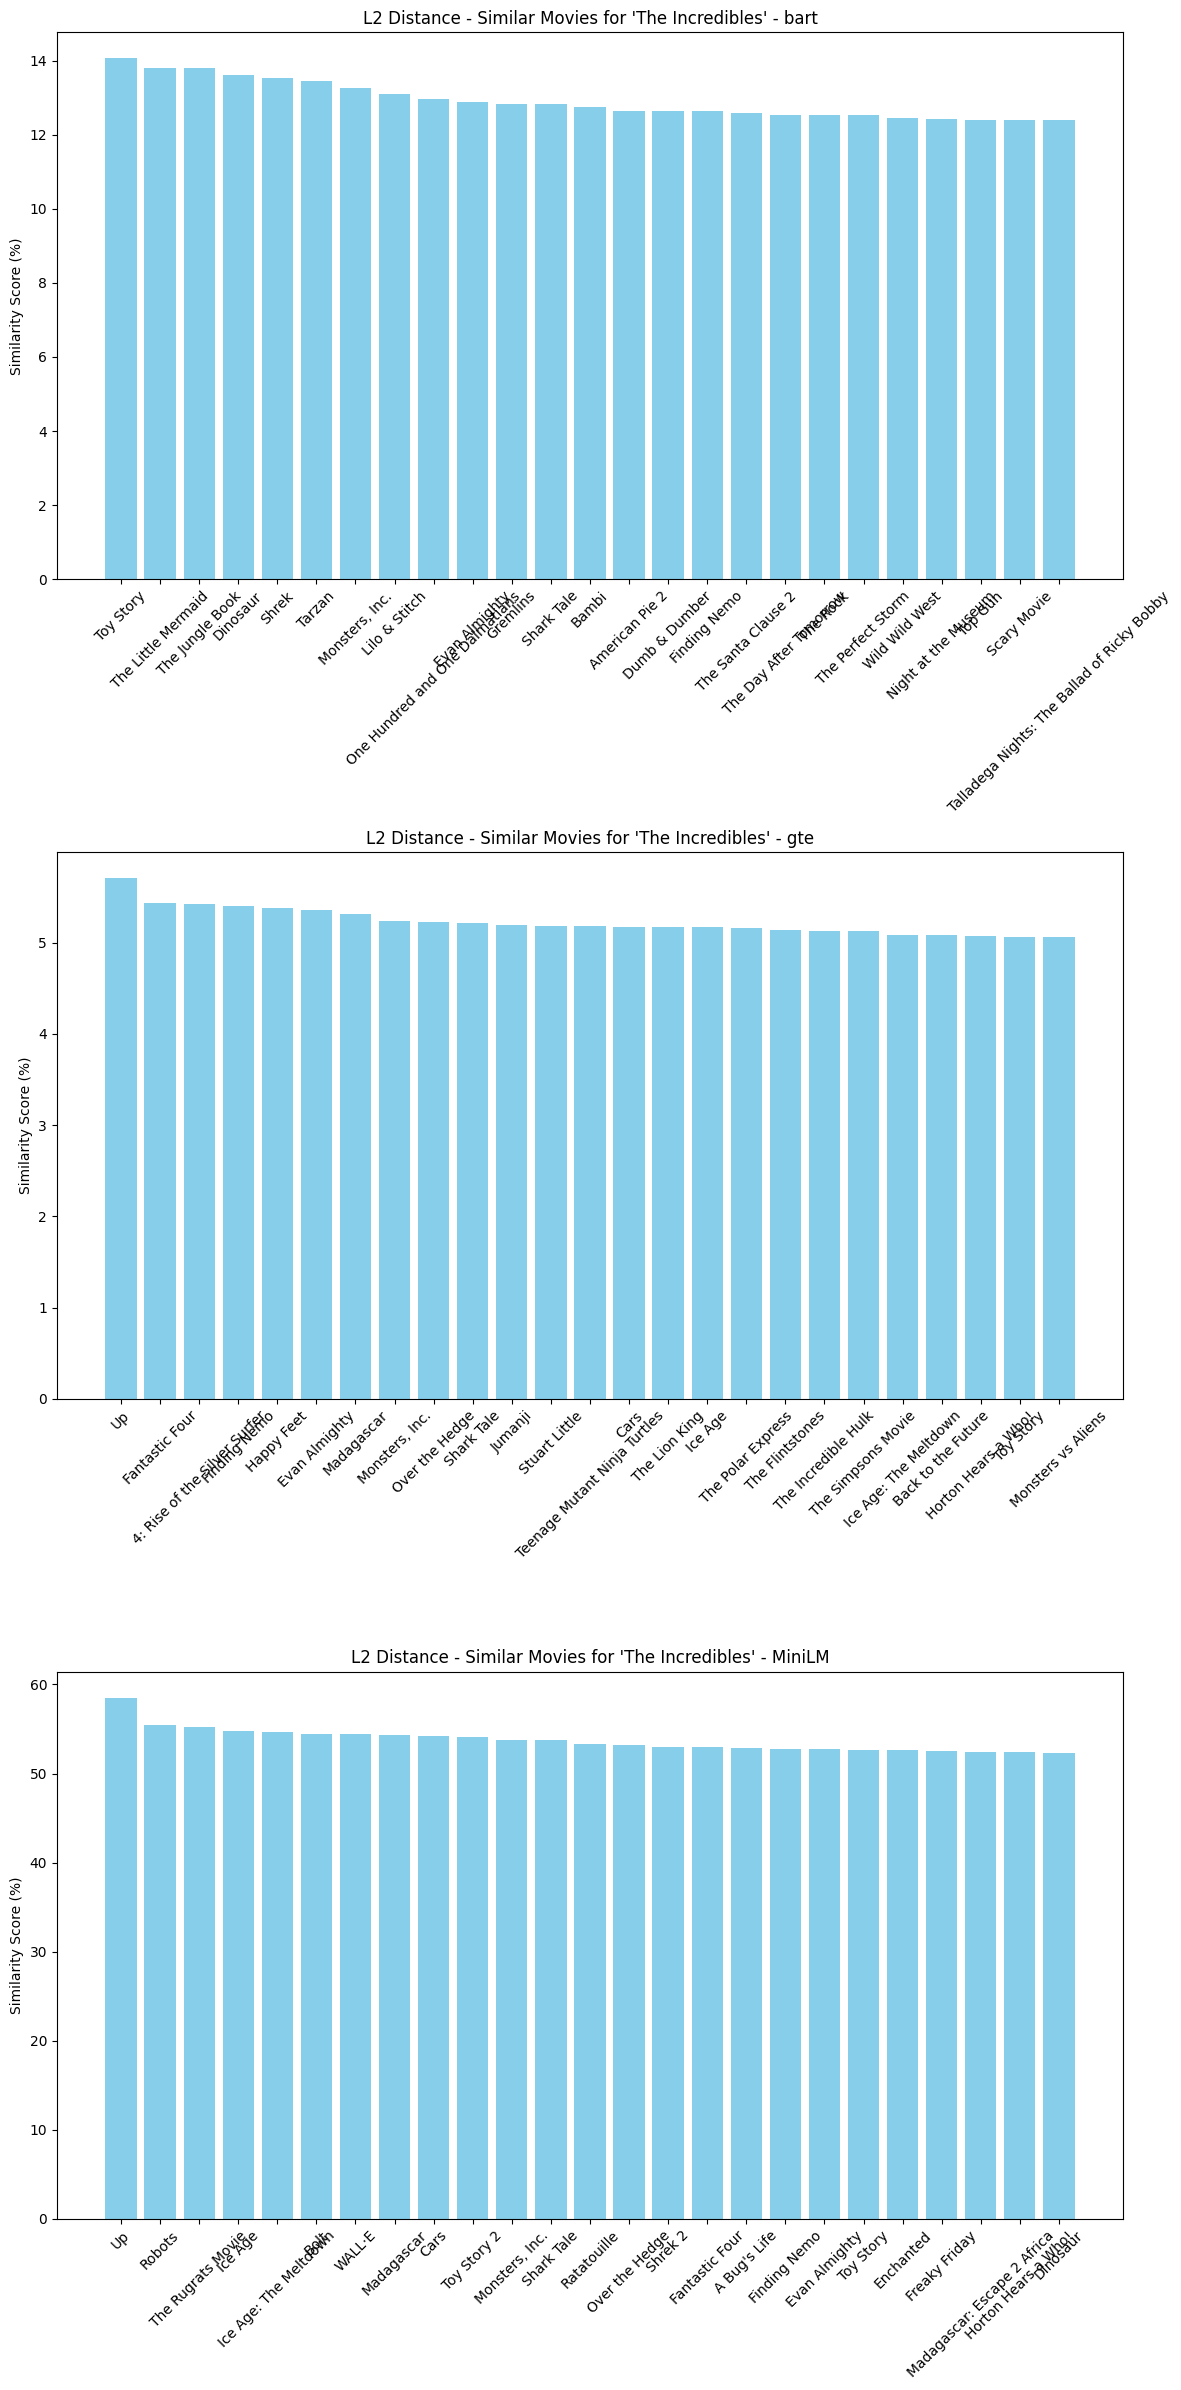

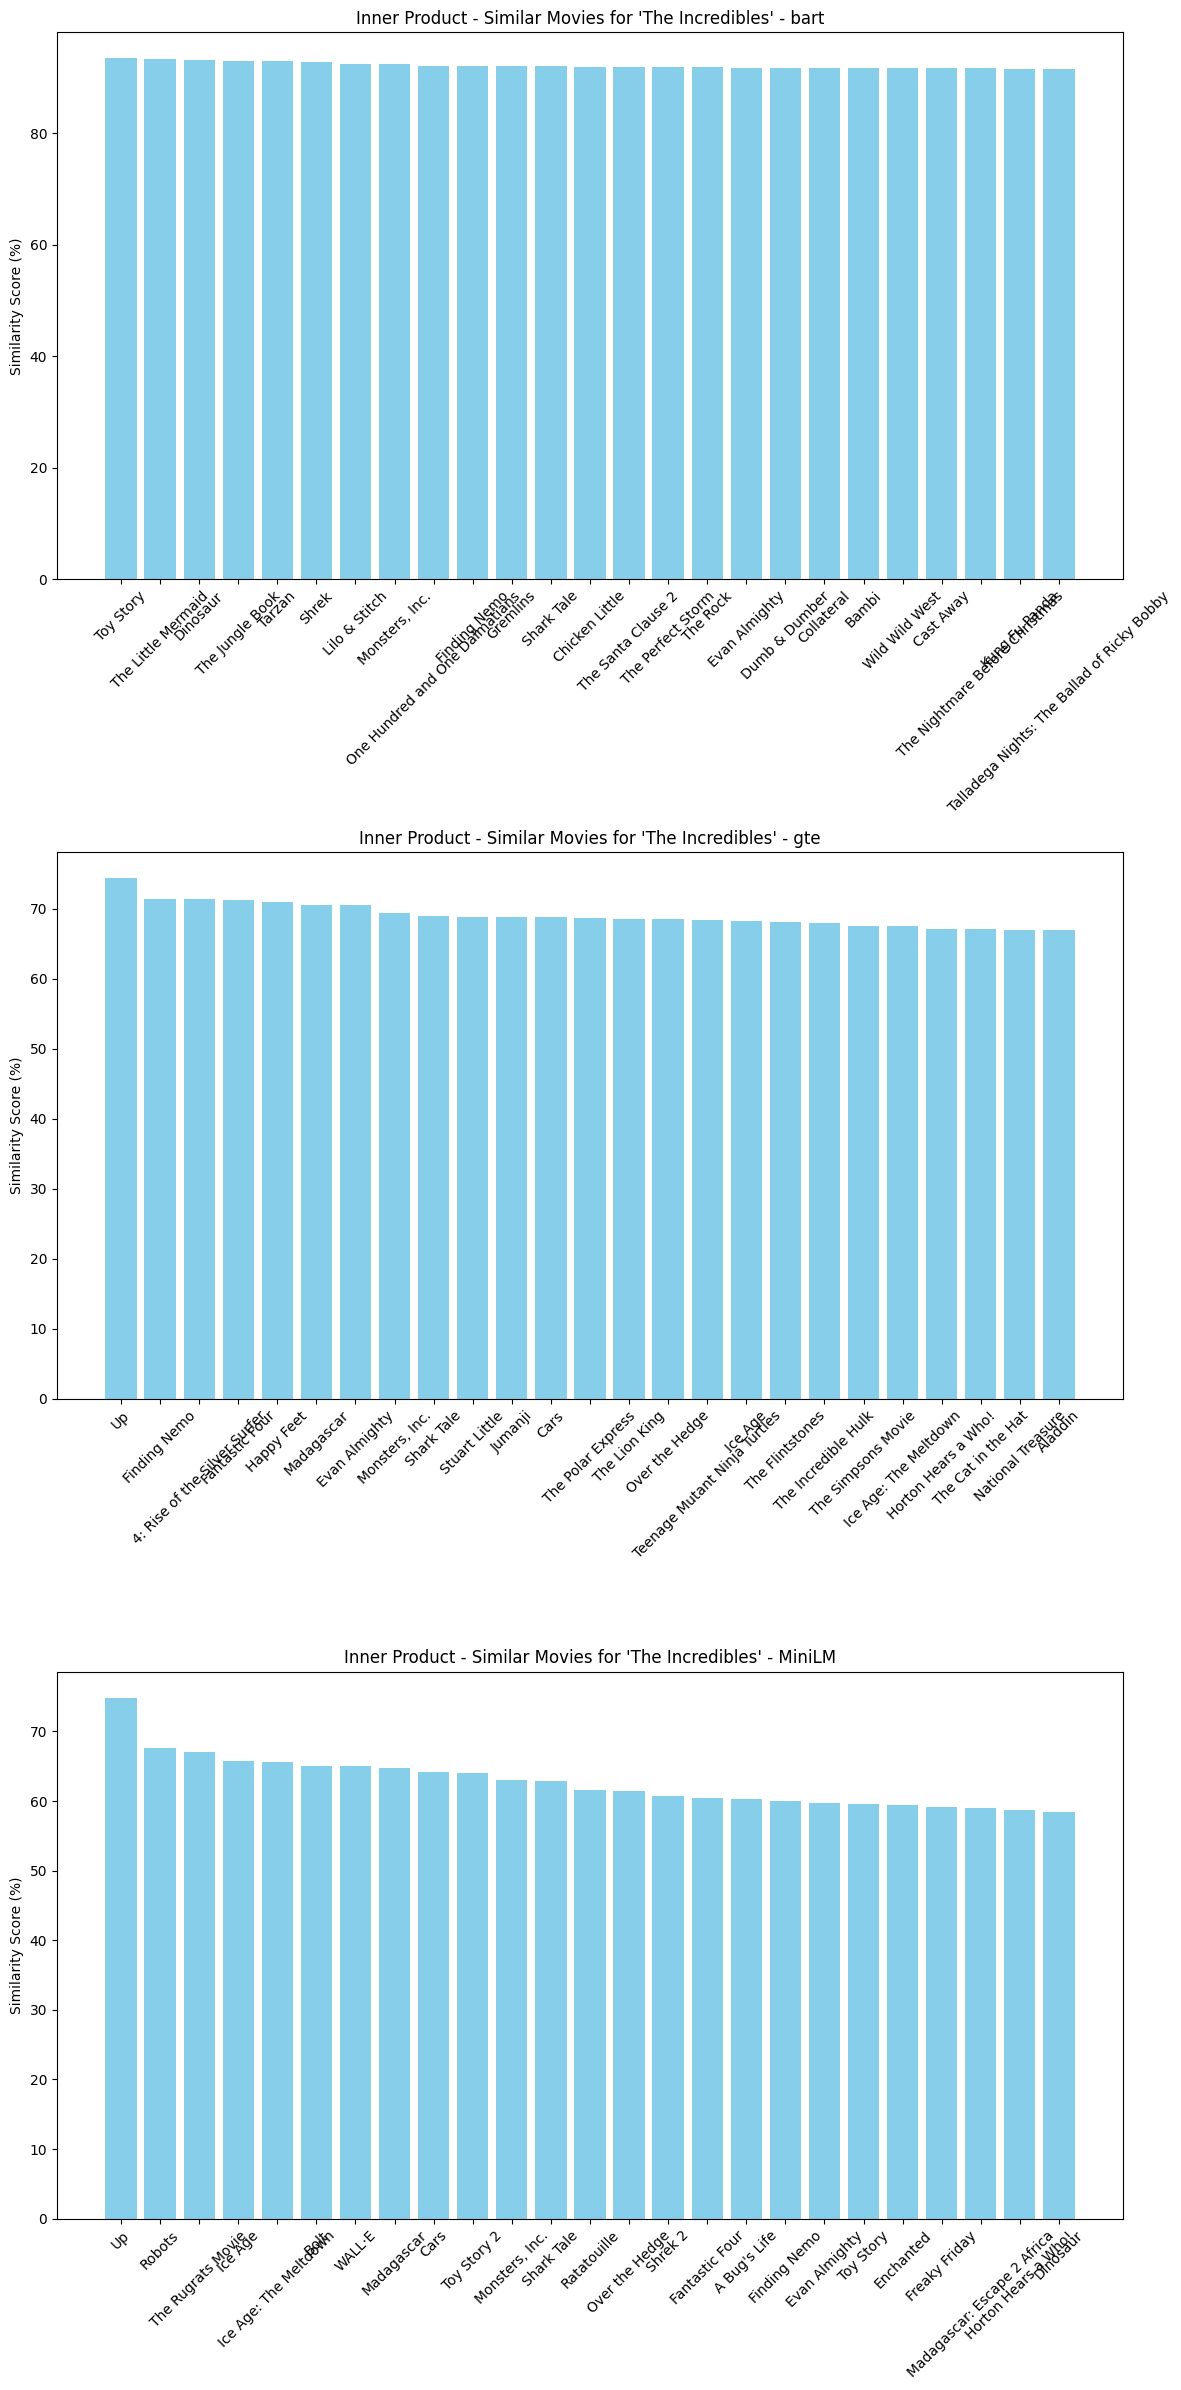

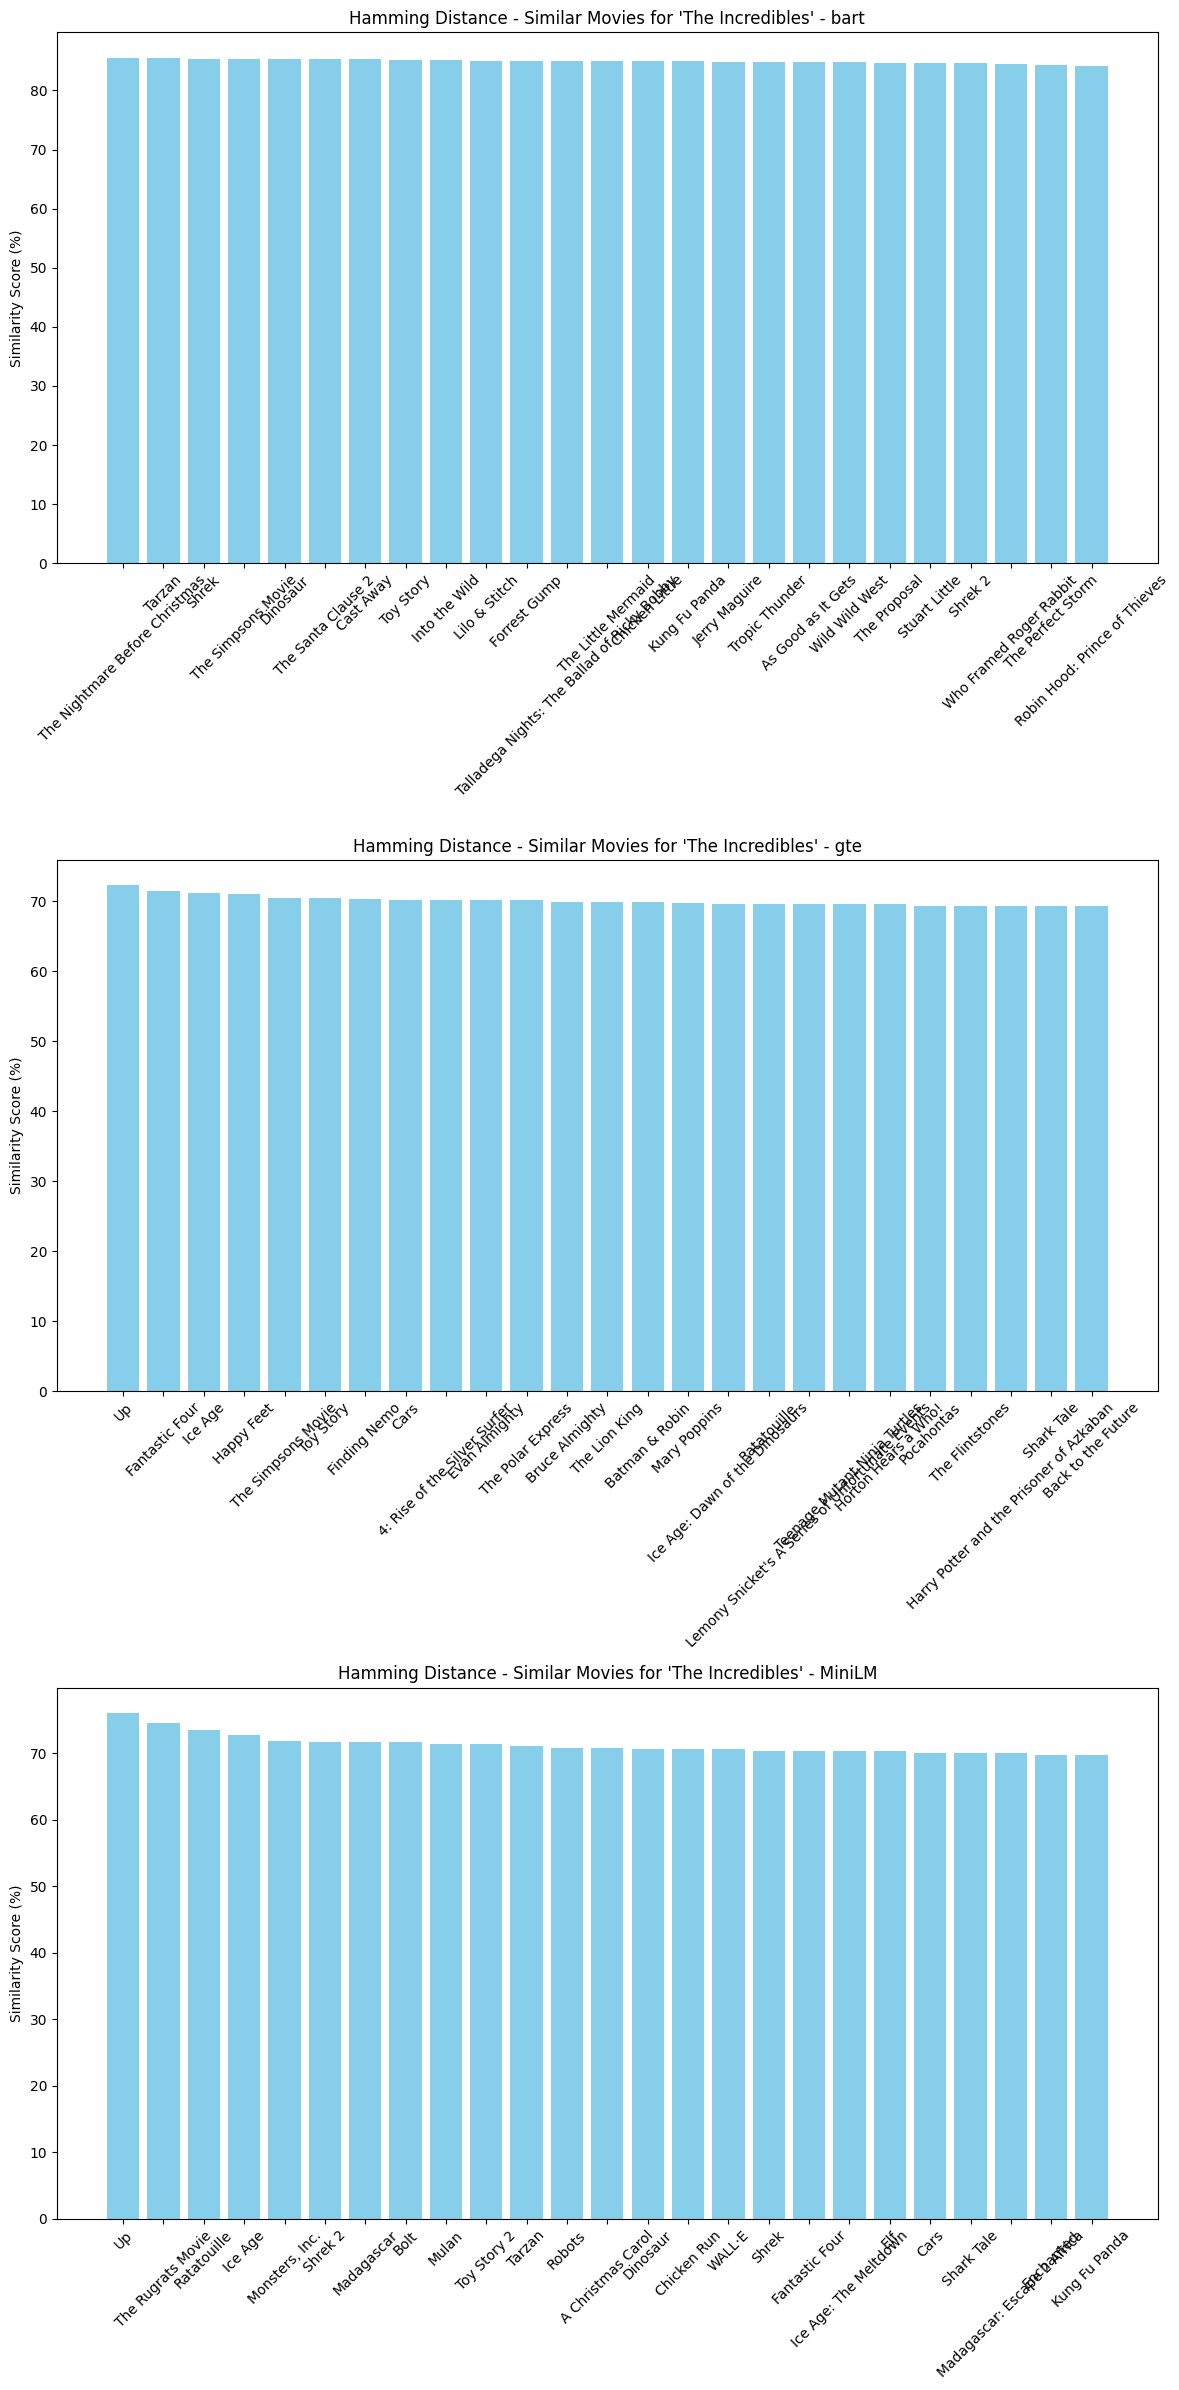

/home/antoine/.pyenv/versions/3.10.11/envs/shinobi/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/antoine/.pyenv/versions/3.10.11/envs/shinobi/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/antoine/.pyenv/versions/3.10.11/envs/shinobi/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


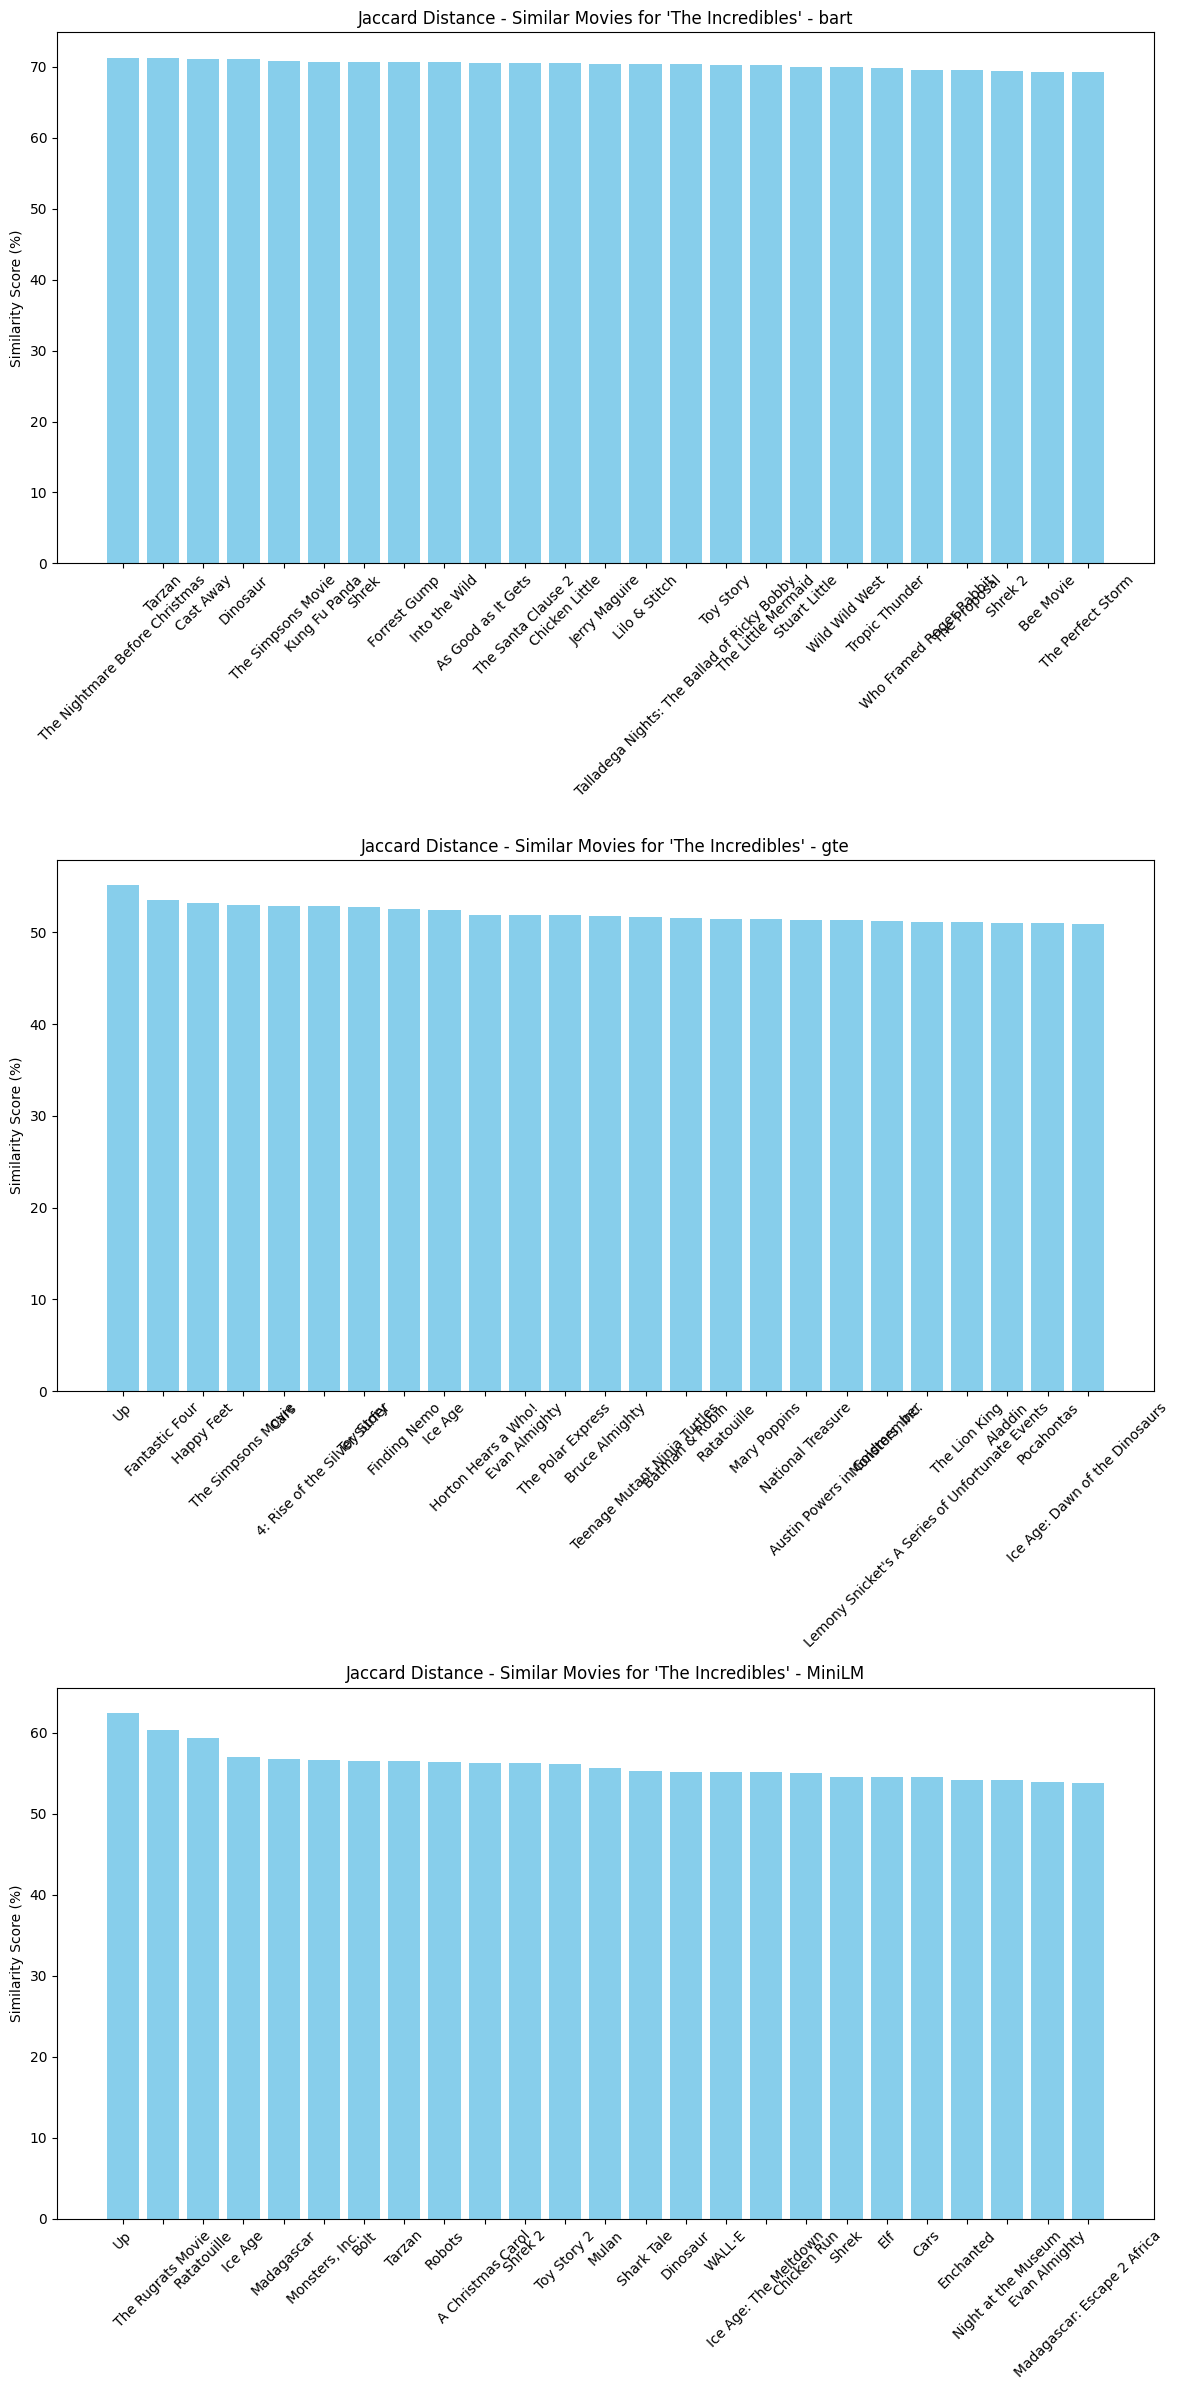

In [152]:
# For cosine similarity
similar_movies_cosine_bart = find_similar_movies(query_movie_title, threshold=0, distance_function='cosine_similarity', embedding_type='bart')
similar_movies_cosine_gte = find_similar_movies(query_movie_title, threshold=0, distance_function='cosine_similarity', embedding_type='gte')
similar_movies_cosine_MiniLM = find_similar_movies(query_movie_title, threshold=0, distance_function='cosine_similarity', embedding_type='MiniLM')
plot_compare_similar_movies_embedding([similar_movies_cosine_bart, similar_movies_cosine_gte, similar_movies_cosine_MiniLM], 'Cosine Similarity')

# For L2 Distance (Euclidean Distance)
similar_movies_l2_bart = find_similar_movies(query_movie_title, threshold=0, distance_function='euclidean_distance', embedding_type='bart')
similar_movies_l2_gte = find_similar_movies(query_movie_title, threshold=0, distance_function='euclidean_distance', embedding_type='gte')
similar_movies_l2_MiniLM = find_similar_movies(query_movie_title, threshold=0, distance_function='euclidean_distance', embedding_type='MiniLM')
plot_compare_similar_movies_embedding([similar_movies_l2_bart, similar_movies_l2_gte, similar_movies_l2_MiniLM], 'L2 Distance')

# For Inner Product
similar_movies_inner_bart = find_similar_movies(query_movie_title, threshold=0, distance_function='inner_product', embedding_type='bart')
similar_movies_inner_gte = find_similar_movies(query_movie_title, threshold=0, distance_function='inner_product', embedding_type='gte')
similar_movies_inner_MiniLM = find_similar_movies(query_movie_title, threshold=0, distance_function='inner_product', embedding_type='MiniLM')
plot_compare_similar_movies_embedding([similar_movies_inner_bart, similar_movies_inner_gte, similar_movies_inner_MiniLM], 'Inner Product')

# For Hamming Distance
similar_movies_hamming_bart = find_similar_movies(query_movie_title, threshold=0, distance_function='hamming_distance', embedding_type='bart')
similar_movies_hamming_gte = find_similar_movies(query_movie_title, threshold=0, distance_function='hamming_distance', embedding_type='gte')
similar_movies_hamming_MiniLM = find_similar_movies(query_movie_title, threshold=0, distance_function='hamming_distance', embedding_type='MiniLM')
plot_compare_similar_movies_embedding([similar_movies_hamming_bart, similar_movies_hamming_gte, similar_movies_hamming_MiniLM], 'Hamming Distance')

# For Jaccard Distance
similar_movies_jaccard_bart = find_similar_movies(query_movie_title, threshold=0, distance_function='jaccard_distance', embedding_type='bart')
similar_movies_jaccard_gte = find_similar_movies(query_movie_title, threshold=0, distance_function='jaccard_distance', embedding_type='gte')
similar_movies_jaccard_MiniLM = find_similar_movies(query_movie_title, threshold=0, distance_function='jaccard_distance', embedding_type='MiniLM')
plot_compare_similar_movies_embedding([similar_movies_jaccard_bart, similar_movies_jaccard_gte, similar_movies_jaccard_MiniLM], 'Jaccard Distance')

